## Importer librairies

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime

import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from scipy.stats import kstest
from scipy.stats import f_oneway
from scipy.stats import wilcoxon

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
#Gestion des options d'affichage 
pd.set_option('display.max_row',1000)
pd.set_option('display.max_columns',30)

## Charger les données

In [3]:
customers= pd.read_csv('customers.csv', sep=',')
products = pd.read_csv('products.csv', sep=',')
transaction= pd.read_csv('transactions.csv', sep=',')

## Exploration des données

### Customers

In [4]:
print("Shape: ",customers.shape)
customers.head()

Shape:  (8623, 3)


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [5]:
customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [6]:
print("Customers uniques \n",customers.nunique() )
print("_" * 20)
print("Valeurs nulls \n", customers.isnull().sum())

Customers uniques 
 client_id    8623
sex             2
birth          76
dtype: int64
____________________
Valeurs nulls 
 client_id    0
sex          0
birth        0
dtype: int64


In [7]:
customers['age'] = 2023 - customers['birth']
customers.head(3)

,client_id,sex,birth,age
0,c_4410,f,1967,56
1,c_7839,f,1975,48
2,c_1699,f,1984,39


In [8]:
customers[customers['age'] > 90]

,client_id,sex,birth,age
418,c_5302,m,1929,94
701,c_2144,f,1932,91
751,c_4812,m,1931,92
1086,c_3218,f,1930,93
1588,c_1455,f,1932,91
2491,c_8362,f,1929,94
2738,c_6154,f,1932,91
3112,c_4334,m,1931,92
3272,c_2438,f,1932,91
3994,c_4679,f,1930,93


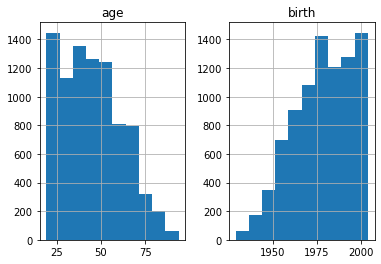

In [9]:
customers.hist()
plt.show()

### Products

In [10]:
print("Shape: ",products.shape)
products.head()

Shape:  (3287, 3)


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [11]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [12]:
print("Products uniques \n",products.nunique() )
print("_" * 20)
print("Valeurs nulls \n", products.isnull().sum())

Products uniques 
 id_prod    3287
price      1455
categ         3
dtype: int64
____________________
Valeurs nulls 
 id_prod    0
price      0
categ      0
dtype: int64


In [13]:
#Il y a trois catégories de productuits
products.categ.unique()

array([0, 1, 2])

In [14]:
products[products['price'] ==-1]

,id_prod,price,categ
731,T_0,-1.0,0


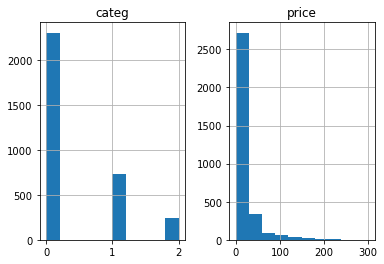

In [15]:
products.hist()
plt.show()

In [16]:
#Eliminer les données test
products.drop(products.loc[products['id_prod'] == 'T_0'].index, inplace=True)

In [17]:
print("Shape après éliminer les données de test: ", products.shape)
print("Vérification:")
products[products['price'] ==-1]

Shape après éliminer les données de test:  (3286, 3)
Vérification:


,id_prod,price,categ


### Transaction

In [18]:
print("Shape:", transaction.shape)
transaction.head()

Shape: (679532, 4)


,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [19]:
print("Transaction uniques \n",transaction.nunique() )
print("_" * 20)
print("Valeurs nulls \n", transaction.isnull().sum())
print("_" * 20)
print("Type de données")
transaction.dtypes

Transaction uniques 
 id_prod         3267
date          679371
session_id    342316
client_id       8602
dtype: int64
____________________
Valeurs nulls 
 id_prod       0
date          0
session_id    0
client_id     0
dtype: int64
____________________
Type de données


id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [20]:
#split colonne date
transaction[['date_s', 'time']] = transaction['date'].str.split(expand=True)

#Eliminer données de test
data_test =transaction[transaction['date_s'] == 'test_2021-03-01']
data_test.columns
data_test.client_id.unique()

data_test.id_prod.unique()
#Eliminer les données test
transaction.drop(transaction.loc[transaction['date_s'] == 'test_2021-03-01'].index,
                 inplace=True)

print("Shape après avoir éliminé les données de test",transaction.shape)

Shape après avoir éliminé les données de test (679332, 6)


In [21]:
#Convertir la colonne au format date
transaction['date_s'] = pd.to_datetime(transaction['date_s'])

# Je récupere le mois et l'année pour après calculer l'évoultion de CA
transaction['month'] = transaction['date_s'].dt.month
transaction['year'] = transaction['date_s'].dt.year

In [22]:
transaction.columns

Index(['id_prod', 'date', 'session_id', 'client_id', 'date_s', 'time', 'month',
       'year'],
      dtype='object')

In [23]:
transaction = transaction[['id_prod', 'session_id', 'client_id', 'date_s', 'month', 'year']]
transaction.head(3)

,id_prod,session_id,client_id,date_s,month,year
0,0_1518,s_211425,c_103,2022-05-20,5,2022
1,1_251,s_158752,c_8534,2022-02-02,2,2022
2,0_1277,s_225667,c_6714,2022-06-18,6,2022


## Jointures

### Jointure products et transaction

In [24]:
# Pour quoi join lefth ? pour ne pas prendre les produits ne pas vendues
prod_trans= pd.merge(transaction, products, on ='id_prod', how='outer', indicator=True)

print("Shape: ",prod_trans.shape)
prod_trans.head(3)

Shape:  (679353, 9)


,id_prod,session_id,client_id,date_s,month,year,price,categ,_merge
0,0_1518,s_211425,c_103,2022-05-20,5.0,2022.0,4.18,0.0,both
1,0_1518,s_95811,c_6197,2021-09-26,9.0,2021.0,4.18,0.0,both
2,0_1518,s_30782,c_682,2021-05-06,5.0,2021.0,4.18,0.0,both


In [25]:
prod_trans._merge.unique()

[both, left_only, right_only]
Categories (3, object): [both, left_only, right_only]

In [26]:
# Les produits vendues ne sont pas dans la data frame products, on ne connait pas le prix.
# Le CA peut être affecté par cette manque d'information.
# Faire l'imputation de valeurs avec la moyenne, categorie 0.#

print("shape: ", prod_trans[prod_trans['_merge'] == 'left_only'].shape)
idx_prod_sans_price = prod_trans[prod_trans['_merge'] == 'left_only'].index
prod_trans[prod_trans['_merge'] == 'left_only']

shape:  (221, 9)


,id_prod,session_id,client_id,date_s,month,year,price,categ,_merge
542560,0_2245,s_272266,c_4746,2022-09-23,9.0,2022.0,NaN,NaN,left_only
542561,0_2245,s_242482,c_6713,2022-07-23,7.0,2022.0,NaN,NaN,left_only
542562,0_2245,s_306338,c_5108,2022-12-03,12.0,2022.0,NaN,NaN,left_only
542563,0_2245,s_76493,c_1391,2021-08-16,8.0,2021.0,NaN,NaN,left_only
542564,0_2245,s_239078,c_7954,2022-07-16,7.0,2022.0,NaN,NaN,left_only
542565,0_2245,s_330241,c_6268,2023-01-21,1.0,2023.0,NaN,NaN,left_only
542566,0_2245,s_300389,c_8524,2022-11-20,11.0,2022.0,NaN,NaN,left_only
542567,0_2245,s_107564,c_1746,2021-10-20,10.0,2021.0,NaN,NaN,left_only
542568,0_2245,s_21906,c_7808,2021-04-17,4.0,2021.0,NaN,NaN,left_only
542569,0_2245,s_172304,c_4964,2022-02-28,2.0,2022.0,NaN,NaN,left_only


#### Imputation par la moyenne de produits vendues sans le price

In [27]:
# Je calcule la moyenne du prix du produits de la categorie 0,
# car tous les id_prod comencent par 0
mean_price = round(prod_trans[prod_trans['categ'] == 0].price.mean(),2)
print("mean: ",mean_price)

# Le total de tous le valeurs nan du merge (left_only), c'est egale à la shape
print("Total de valeurs NAN:",prod_trans.price.isna().sum() )

#Imputation avec la moyenne
prod_trans.price.fillna(mean_price, inplace=True)

#Remplir avec 0 dans la colonne categ 
prod_trans.categ.fillna(0, inplace = True)

#je verifie que l'imputation est faite
prod_trans[prod_trans['_merge'] == 'left_only'].head()

mean:  10.64
Total de valeurs NAN: 221


,id_prod,session_id,client_id,date_s,month,year,price,categ,_merge
542560,0_2245,s_272266,c_4746,2022-09-23,9.0,2022.0,10.64,0.0,left_only
542561,0_2245,s_242482,c_6713,2022-07-23,7.0,2022.0,10.64,0.0,left_only
542562,0_2245,s_306338,c_5108,2022-12-03,12.0,2022.0,10.64,0.0,left_only
542563,0_2245,s_76493,c_1391,2021-08-16,8.0,2021.0,10.64,0.0,left_only
542564,0_2245,s_239078,c_7954,2022-07-16,7.0,2022.0,10.64,0.0,left_only


In [28]:
# 21 Produits non vendus
prod_trans[prod_trans['_merge'] == 'right_only']

,id_prod,session_id,client_id,date_s,month,year,price,categ,_merge
679332,0_1016,NaN,NaN,NaT,NaN,NaN,35.06,0.0,right_only
679333,0_1780,NaN,NaN,NaT,NaN,NaN,1.67,0.0,right_only
679334,0_1062,NaN,NaN,NaT,NaN,NaN,20.08,0.0,right_only
679335,0_1119,NaN,NaN,NaT,NaN,NaN,2.99,0.0,right_only
679336,0_1014,NaN,NaN,NaT,NaN,NaN,1.15,0.0,right_only
679337,1_0,NaN,NaN,NaT,NaN,NaN,31.82,1.0,right_only
679338,0_1318,NaN,NaN,NaT,NaN,NaN,20.92,0.0,right_only
679339,0_1800,NaN,NaN,NaT,NaN,NaN,22.05,0.0,right_only
679340,0_1645,NaN,NaN,NaT,NaN,NaN,2.99,0.0,right_only
679341,0_322,NaN,NaN,NaT,NaN,NaN,2.99,0.0,right_only


In [29]:
#Eliminer les produits non vendus
prod_trans.drop(prod_trans[prod_trans['_merge'] == 'right_only'].index, inplace=True)

# Vérification s'ils sont éliminés
prod_trans[prod_trans['_merge'] == 'right_only']

,id_prod,session_id,client_id,date_s,month,year,price,categ,_merge


In [30]:
# J'élimine la colonne _merge, sinon ça ne permet pas de faire une 2em jointure
prod_trans.drop(['_merge'], axis=1, inplace=True)

### Jointure products, transaction and customers

In [31]:
ventes = pd.merge(prod_trans, customers, on ='client_id', how='outer', indicator= True)
print("Shape: ", ventes.shape)
ventes.head(3)

Shape:  (679355, 12)


,id_prod,session_id,client_id,date_s,month,year,price,categ,sex,birth,age,_merge
0,0_1518,s_211425,c_103,2022-05-20,5.0,2022.0,4.18,0.0,f,1986,37,both
1,0_1518,s_64849,c_103,2021-07-20,7.0,2021.0,4.18,0.0,f,1986,37,both
2,0_1518,s_255965,c_103,2022-08-20,8.0,2022.0,4.18,0.0,f,1986,37,both


In [32]:
#Clients qui n'ont pas fait d'achats
ventes[ventes['_merge'] == 'right_only']

,id_prod,session_id,client_id,date_s,month,year,price,categ,sex,birth,age,_merge
679332,NaN,NaN,c_8253,NaT,NaN,NaN,NaN,NaN,f,2001,22,right_only
679333,NaN,NaN,c_3789,NaT,NaN,NaN,NaN,NaN,f,1997,26,right_only
679334,NaN,NaN,c_4406,NaT,NaN,NaN,NaN,NaN,f,1998,25,right_only
679335,NaN,NaN,ct_0,NaT,NaN,NaN,NaN,NaN,f,2001,22,right_only
679336,NaN,NaN,c_2706,NaT,NaN,NaN,NaN,NaN,f,1967,56,right_only
679337,NaN,NaN,c_3443,NaT,NaN,NaN,NaN,NaN,m,1959,64,right_only
679338,NaN,NaN,c_4447,NaT,NaN,NaN,NaN,NaN,m,1956,67,right_only
679339,NaN,NaN,c_3017,NaT,NaN,NaN,NaN,NaN,f,1992,31,right_only
679340,NaN,NaN,c_4086,NaT,NaN,NaN,NaN,NaN,f,1992,31,right_only
679341,NaN,NaN,c_6930,NaT,NaN,NaN,NaN,NaN,m,2004,19,right_only


In [33]:
# Vérification si les produits ne pas vendues apparaissent
ventes[ventes['_merge'] == 'left_only']

,id_prod,session_id,client_id,date_s,month,year,price,categ,sex,birth,age,_merge


## Graphiques évolution du CA dans le temps

In [34]:
sums = ventes.groupby(['categ', 'month'])['price'].sum().reset_index(level=0)

In [35]:
def plot_ca (year,ventes):
    sums = ventes[ventes['year'] == year].groupby(['categ', 'month'])['price'].sum().reset_index(level=0)
    plt.title('CA en {}'.format(year))
   #plt.legend()   
    for c in sums['categ'].unique():        
        sums[sums['categ'] == c]['price'].plot(figsize=(12,7));

### Graphique CA par an et par catégorie

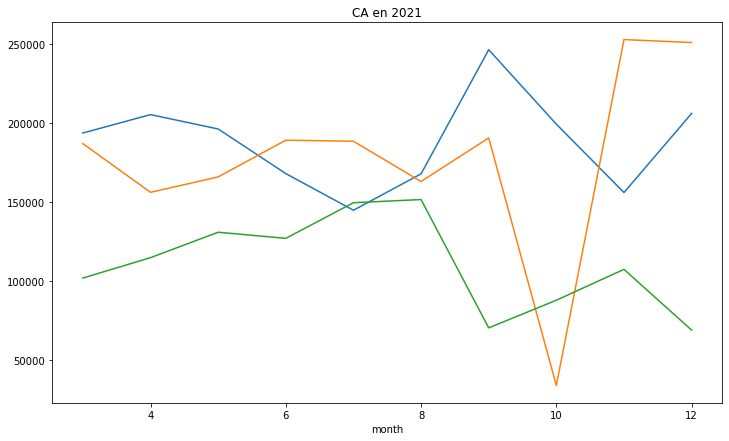

In [36]:
# Il n'y a pas de données dans le mois d'oct
plot_ca(2021, ventes)
# blue cat 0,orange cat 1, vert cat 2

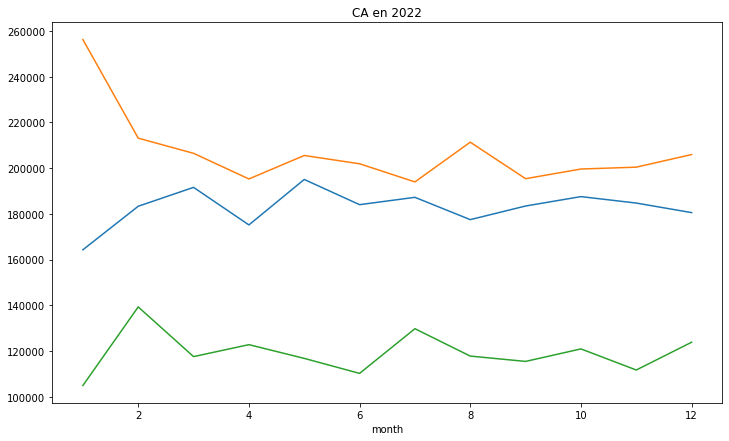

In [37]:
plot_ca(2022,ventes)

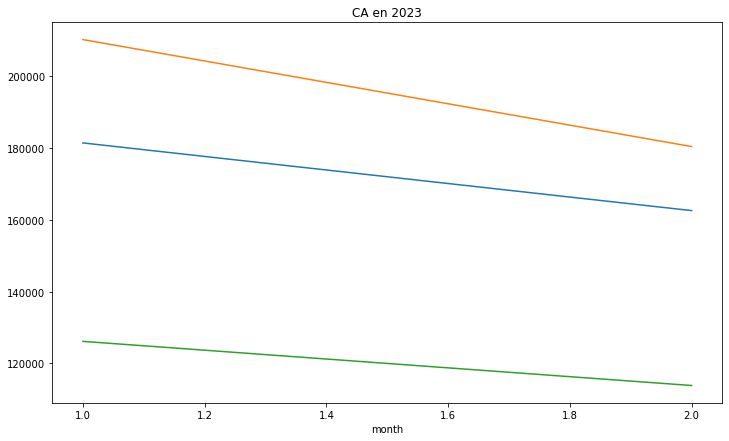

In [38]:
plot_ca(2023,ventes)

### Enlever le mois d'octobre pour l'année 2021

In [39]:
ventes.drop(ventes.loc[(ventes['year'] == 2021) & (ventes['month'] == 10)].index, inplace=True)
print("Sahpe:", ventes.shape)

Sahpe: (657749, 12)


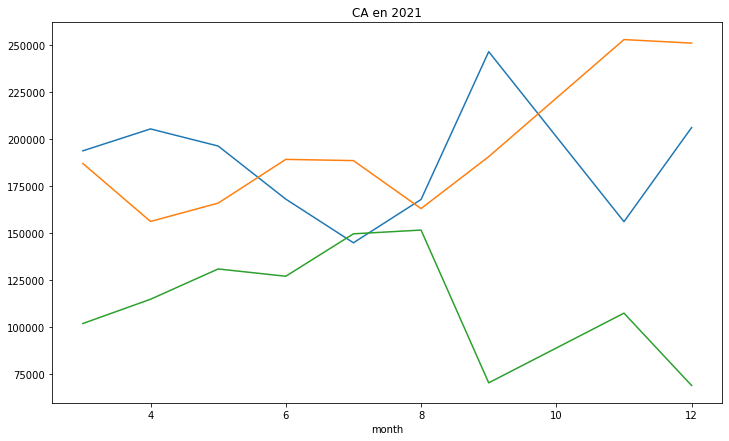

In [40]:
plot_ca(2021,ventes)

### Décomposition en moyenne mobile pour évaluer la tendance globale

In [41]:
ventes2 =ventes[['id_prod', 'session_id', 'client_id','date_s', 'month','year', 'price', 'categ', 'sex', 'birth', 'age']]

In [42]:
ventes2.columns = ['id_prod', 'session_id', 'client_id', 'date','month','year', 'price', 'categ', 'sex', 'birth', 'age']
#print("Shape: ", ventes2.shape)

ventes2['date'] = ventes2['date'].dt.to_period('M')
ventes2.drop(ventes2.loc[ventes2['date']==2021-10].index,inplace=True)

print("Shape sans octobre: ", ventes2.shape)

ca_month2 = ventes2[['date', 'price']].copy()
ca_month2.set_index('date', inplace=True)
ca_month2.head(3)

Shape sans octobre:  (657749, 11)


<ipython-input-42-9aca986f5930>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes2['date'] = ventes2['date'].dt.to_period('M')
/home/ac/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,price
date,
2022-05,4.18
2021-07,4.18
2022-08,4.18


In [43]:
# Le group_by je dois le faire par mois, car j'ai perdu la semaine

ca_month2= ca_month2.groupby(pd.Grouper(freq="M"))['price'].sum().reset_index(level=0)
ca_month2.head(3)

,date,price
0,2021-03,482536.37
1,2021-04,476258.26
2,2021-05,493028.59


In [44]:
ca_month2[ '4week_rolling_avg' ] = ca_month2.price.rolling(4).mean() 
ca_month2

,date,price,4week_rolling_avg
0,2021-03,482536.37,NaN
1,2021-04,476258.26,NaN
2,2021-05,493028.59,NaN
3,2021-06,484163.04,483996.5650
4,2021-07,482877.96,484081.9625
5,2021-08,482380.55,485612.5350
6,2021-09,507368.36,489197.4775
7,2021-10,0.00,368156.7175
8,2021-11,516274.13,376505.7600
9,2021-12,525991.76,387408.5625


In [45]:
ca_month2['date'] = ca_month2['date'].astype(str)
ca_month2['date'] = pd.to_datetime(ca_month2['date'])
ca_month2.dtypes

date                 datetime64[ns]
price                       float64
4week_rolling_avg           float64
dtype: object

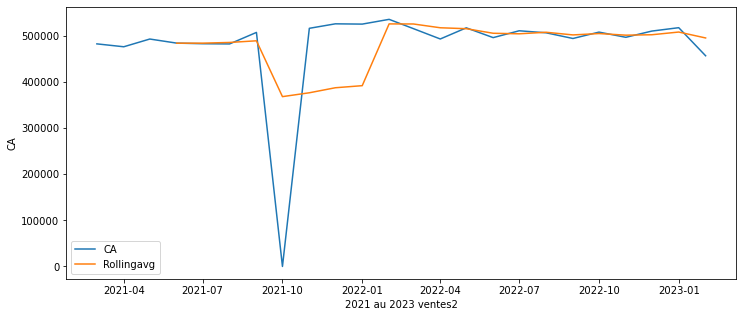

In [46]:
plt.figure( figsize = ( 12, 5)) 

sns.lineplot( x = 'date', 
             y = 'price', 
             data = ca_month2, 
             label = 'CA')

sns.lineplot( x = 'date', 
             y = '4week_rolling_avg', 
             data = ca_month2, 
             label = 'Rollingavg')

plt.xlabel('2021 au 2023 ventes2')
plt.ylabel('CA') 
plt.show()

## Les tops , les flops et la répartition de CA par catégorie.

In [47]:
def tops_flops_prod(df,categ):
    data = df[df['categ'] == categ]
    ca = data.groupby(['id_prod'])['price'].sum().reset_index(level=0)
    tops = ca.sort_values('price', ascending=False).head(10)
    flops = ca.sort_values('price').head(10)
    
    return tops,flops

top_0,flop_0 = tops_flops_prod(ventes, 0)
top_1,flop_1 = tops_flops_prod(ventes, 1)
top_2,flop_2 = tops_flops_prod(ventes, 2)

In [48]:
print("Top 10 de produits categorie 0")
top_0

Top 10 de produits categorie 0


,id_prod,price
486,0_1441,22389.21
464,0_1421,21809.09
456,0_1414,21395.52
497,0_1451,20789.60
459,0_1417,20364.68
493,0_1448,19754.42
474,0_1430,19253.43
518,0_1470,19197.99
389,0_1353,18650.67
391,0_1355,18401.31


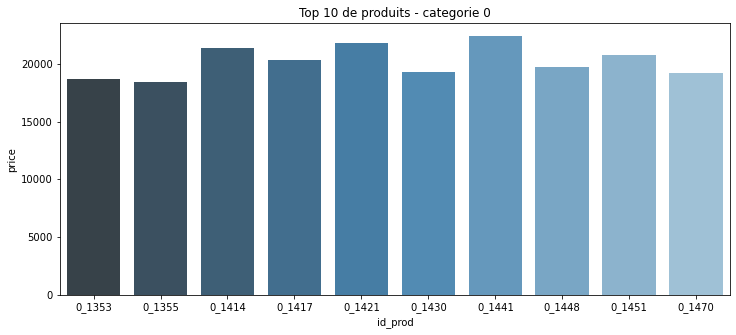

In [49]:
f, ax = plt.subplots(figsize=(12,5)) 
ax.set_title('Top 10 de produits - categorie 0')
ax = sns.barplot(x="id_prod", y="price", data=top_0, palette="Blues_d")

In [50]:
print("Flops de produits categorie 0")
flop_0

Flops de produits categorie 0


,id_prod,price
594,0_1539,0.99
2178,0_898,1.27
313,0_1284,1.38
1896,0_643,1.98
718,0_1653,1.98
2078,0_807,1.99
1783,0_541,1.99
664,0_1601,1.99
801,0_1728,2.27
1543,0_324,2.36


In [51]:
print("Top 10 de produits categorie 1")
top_1

Top 10 de produits categorie 1


,id_prod,price
327,1_395,53950.39
299,1_369,53665.63
349,1_414,51615.78
315,1_383,51080.38
441,1_498,49474.29
340,1_406,47908.11
296,1_366,46691.44
317,1_385,46496.11
368,1_431,46323.45
309,1_378,45875.64


In [52]:
print("Flops de produits categorie 1")
flop_1

Flops de produits categorie 1


,id_prod,price
356,1_420,14.24
139,1_224,19.80
411,1_470,21.64
414,1_473,26.91
338,1_404,29.55
40,1_135,39.95
331,1_399,43.89
457,1_511,44.85
375,1_438,47.16
360,1_424,49.10


In [53]:
print("Top 10 de produits categorie 2")
top_2

Top 10 de produits categorie 2


,id_prod,price
67,2_159,92265.68
41,2_135,67403.23
16,2_112,62840.10
5,2_102,58962.58
123,2_209,55362.09
14,2_110,51916.50
172,2_39,51147.18
75,2_166,51068.88
177,2_43,48363.09
116,2_202,44393.49


In [54]:
print("Flops de produits categorie 2")
flop_2

Flops de produits categorie 2


,id_prod,price
218,2_81,86.99
146,2_23,115.99
234,2_98,149.74
229,2_93,157.98
10,2_107,203.94
37,2_131,255.98
27,2_122,280.00
213,2_77,291.98
159,2_27,295.96
202,2_66,301.44


In [55]:
# Les clients tops et flops

ca_client = ventes.groupby(['client_id'])['price'].sum().reset_index(level=0)
tops = ca_client.sort_values('price', ascending=False).head(10)
flops = ca_client[ca_client['price'] > 0].sort_values('price').head(10)

In [56]:
tops

,client_id,price
678,c_1609,312755.08
4397,c_4958,282654.61
6349,c_6714,149847.59
2727,c_3454,111798.63
2110,c_2899,5214.05
635,c_1570,5136.14
2516,c_3263,5129.89
7021,c_7319,5120.55
7807,c_8026,4980.05
4737,c_5263,4964.87


In [57]:

flops

,client_id,price
7934,c_8140,8.30
7905,c_8114,9.98
1557,c_240,11.06
4053,c_4648,11.20
1993,c_2793,12.99
3864,c_4478,13.36
5513,c_5962,13.99
5601,c_6040,15.72
5465,c_5919,15.98
5365,c_5829,16.07


## Courbe de Lorentz et gini

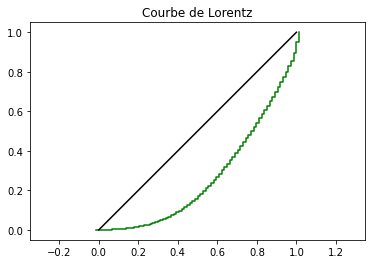

In [58]:
# CA par age 
ca_age = ventes.groupby(['age'])['price'].sum().reset_index(level=0)

ca = ca_age['price'].values
n = len(ca)
lorenz = np.cumsum(np.sort(ca)) / ca.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n, 1+1/n, n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis, lorenz, drawstyle='steps-post', color='green')
## line plot of equality
plt.plot([0,1], [0,1], color='k')
plt.title("Courbe de Lorentz")
plt.show()

In [59]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print("Coefficient de Gini: ",gini)

Coefficient de Gini:  0.4463491271048772


## Analyse plus ciblée sur les clients

### Le lien entre le genre d’un client et les catégories des livres achetés

H0: Pas de relation entre le sexe et catégorie

In [60]:
# Deux variables Qualitatives: Sexe - Catégorie
X = "sex"
Y = "categ"
#le tableau de contingence es calculé par pivot table 
cont = ventes[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,0.0,1.0,2.0,Total
sex,,,,
f,197098,114087,16722,327907
m,199813,111416,18590,329819
Total,396911,225503,35312,657726


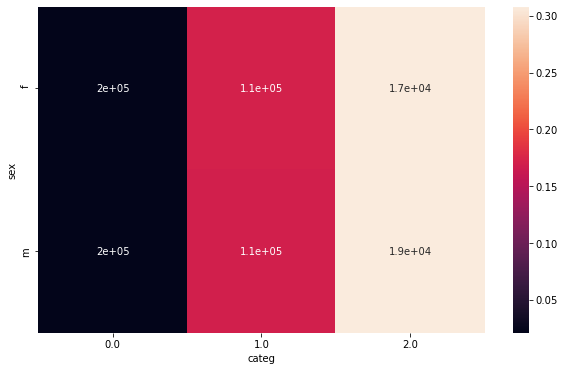

In [61]:
import seaborn as sns

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(ventes)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
plt.figure(figsize=(10,6))
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])

plt.show()

In [62]:
def test_pValue (p):
    print("P-val:", p)
    if p < 0.05:
        print("L'hypothèse nulle est rejeté")
    else:
        print("L'hypothèse nulle est accepté") 

In [63]:
#P-val is considered 'significant' usually if this value is below 0.05, 
#which in this case it is. This indicates then an association between the two variables
#(one has an impact on the other).

chiVal, pVal, df, exp = chi2_contingency(cont)
print("chi-2:",chiVal)

test_pValue(pVal)

chi-2: 143.4684942757229
P-val: 1.8567023620869968e-28
L'hypothèse nulle est rejeté


Alors, il y a de rélation entre sexe et catégorie

###  Le lien entre l’âge des clients et le montant total des achats: Deux variables quantitatives: Age - CA aporté

H0: Pas de relation entre l'âge et le chiffre d'affaire apporté

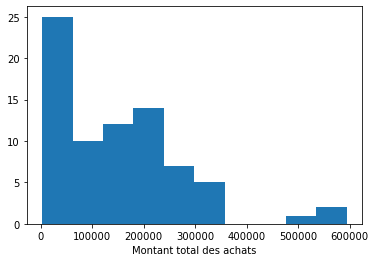

In [64]:
plt.hist(ca_age['price'], bins= 10)
plt.xlabel("Montant total des achats")
plt.show()

In [65]:
# Prix suit une lois normale?
kstest(ca_age['price'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

Since the p-value is less than .05, we reject the null hypothesis. We have sufficient evidence to say that the sample data does not come from a normal distribution.


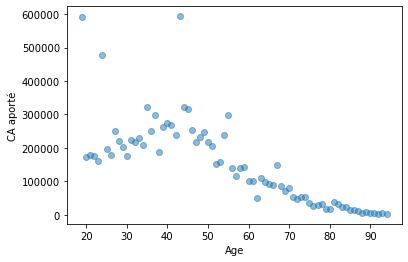

In [66]:
#variable quantitative/quantitative
#le lien entre l’âge des clients et le montant total des achats

plt.scatter(ca_age['age'], ca_age['price'], alpha=0.5)
plt.xlabel("Age")
plt.ylabel("CA aporté")
plt.show()

In [67]:
# le prix ne suit pas une loi normale, alors on fait un test non paramétrique
# pour deux exemples --> Wilcoxon

stat, p = wilcoxon(ca_age['age'], ca_age['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
test_pValue(p)

Statistics=0.000, p=0.000
P-val: 3.6060528034893936e-14
L'hypothèse nulle est rejeté


Alors, il y a de rélation entre l'age et le chiffre d'affaire aporté


### Lien entre âge des clients et la fréquence d’achat

H0: Pas de rélation entre l'âge et la fréquence d'achat


In [68]:
freq_achat = ventes[['id_prod','age']].groupby(['age']).count().reset_index(level=0)
freq_achat.head()

,age,id_prod
0,19,14769
1,20,4238
2,21,4468
3,22,4161
4,23,4299


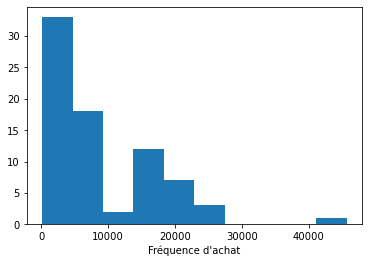

In [69]:
# Fréquence d'achat suit une lois normale?
plt.hist(freq_achat['id_prod'], bins= 10)
plt.xlabel("Fréquence d'achat")
plt.show()

In [70]:
kstest(freq_achat['id_prod'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

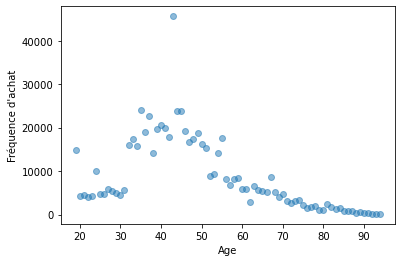

In [71]:
plt.scatter(freq_achat['age'], freq_achat['id_prod'], alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Fréquence d'achat")
plt.show()

In [72]:
# Alors on fait test non paramétrique
# Faire testwilcoxon

stat, p = wilcoxon(freq_achat['age'], freq_achat['id_prod'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
test_pValue(p)

Statistics=0.000, p=0.000
P-val: 3.6060528034893936e-14
L'hypothèse nulle est rejeté


Alors, il y a de rélation entre l'age et la fréquence d'achat

### Lien entre  l'âge des clients et la taille du panier moyen

In [73]:
session_panier = ventes.groupby(['age','session_id'])['price'].sum().reset_index()
session_panier.head(3)

,age,session_id,price
0,19,s_10098,26.30
1,19,s_10128,13.11
2,19,s_10162,62.44


In [74]:
panier_moyen = session_panier.groupby(['age']).mean().reset_index()
panier_moyen.head(3)

,age,price
0,19,70.904475
1,20,69.577999
2,21,70.755485


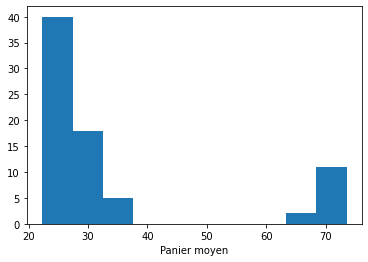

In [75]:
# Requence d'achat suit une lois normale?
plt.hist(panier_moyen['price'], bins= 10)
plt.xlabel("Panier moyen")
plt.show()

In [76]:
kstest(panier_moyen['price'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

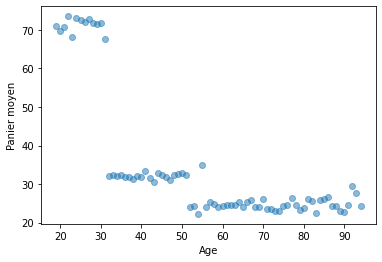

In [77]:
plt.scatter(panier_moyen['age'], panier_moyen['price'], alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Panier moyen")
plt.show()

In [78]:
# Alors on fait test non paramétrique
# Faire testwilcoxon

stat, p = wilcoxon(panier_moyen['age'], panier_moyen['price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
test_pValue(p)

Statistics=602.000, p=0.000
P-val: 8.28434905658773e-06
L'hypothèse nulle est rejeté


Alors, il y a de rélation entre age et la taille de panier

### Lien entre âge et les catégories des livres achetés. Variable quantitative et une qualitative: Age - Catégorie 

H0: Pas de rélation entre catégorie et age


In [79]:
X = "categ" # qualitative
Y = "age" # quantitative

In [80]:
# si pval < 0.05, normal distribution is not assumed
#else: normal distribution is assumed

kstest(ventes["age"], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [81]:
ks_2samp(ventes["age"], ventes["categ"])
#statistic value is higher than the critical value, the two distributions are different.

KstestResult(statistic=0.9999650322539448, pvalue=0.0)

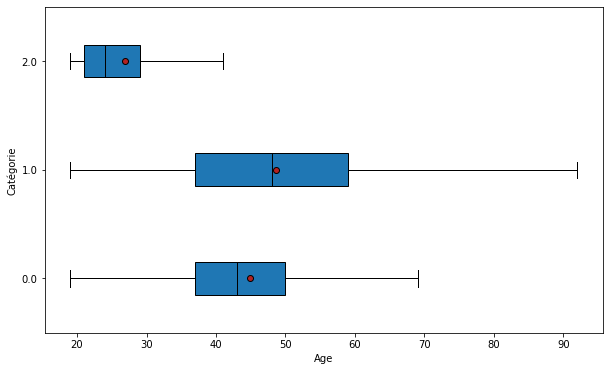

In [82]:
#modalites = ventes[X].unique()
modalites = [ 0.,  1.,  2.]
groupes = []
for m in modalites:
    groupes.append(ventes[ventes[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(10,6))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("Age")
plt.ylabel("Catégorie")
plt.show()

In [83]:
F, p = f_oneway(groupes[0], groupes[1], groupes[2])

test_pValue(p)

P-val: 0.0
L'hypothèse nulle est rejeté


 Alors, il y a une rélation entre catégorie et age